In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
np.random.seed(42)

##DATASET GENERATION

In [ ]:
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=8,
    n_redundant=2,
    n_classes=5,
    n_clusters_per_class=1,
    random_state=42
)

##Split dataset for training and testing

In [ ]:
def one_hot_encode(y, num_classes):
    n_samples = len(y)
    one_hot = np.zeros((n_samples, num_classes))
    one_hot[np.arange(n_samples), y] = 1
    return one_hot

y_one_hot = one_hot_encode(y, 5)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_one_hot, test_size=0.2, random_state=42
)\

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print(f"Input features: {X_train.shape[1]}")
print(f"Output classes: {y_train.shape[1]}")
print()


Training samples: 800
Testing samples: 200
Input features: 10
Output classes: 5



# Neural network builllding and code modification

In [ ]:
class MultiClassNeuralNetwork:
    def __init__(self, input_size, h1_size, h2_size, h3_size, output_size,
                 learning_rate=0.01, dropout_rate=0.1, l2_lambda=0.01):

        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda

        self.W1 = np.random.randn(input_size, h1_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, h1_size))

        self.W2 = np.random.randn(h1_size, h2_size) * np.sqrt(2.0 / h1_size)
        self.b2 = np.zeros((1, h2_size))

        self.W3 = np.random.randn(h2_size, h3_size) * np.sqrt(2.0 / h2_size)
        self.b3 = np.zeros((1, h3_size))

        self.W4 = np.random.randn(h3_size, output_size) * np.sqrt(2.0 / h3_size)
        self.b4 = np.zeros((1, output_size))


    def relu(self, Z):

        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return (Z > 0).astype(float)

    def softmax(self, Z):

        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

    def dropout(self, A, training=True):

        if training and self.dropout_rate > 0:

            mask = np.random.binomial(1, 1 - self.dropout_rate, size=A.shape)

            return A * mask / (1 - self.dropout_rate), mask
        else:

            return A, None

    def cross_entropy_loss(self, y_true, y_pred):

        m = y_true.shape[0]
        epsilon = 1e-8
        return -np.sum(y_true * np.log(y_pred + epsilon)) / m

    def forward_propagation(self, X, training = True):


        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.relu(self.Z1)
        self.A1, self.mask1 = self.dropout(self.A1,training)


        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.relu(self.Z2)
        self.A2, self.mask2 = self.dropout(self.A2,training)


        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.A3 = self.relu(self.Z3)
        self.A3, self.mask3 = self.dropout(self.A3, training)


        self.Z4 = np.dot(self.A3, self.W4) + self.b4
        self.A4 = self.softmax(self.Z4)

        return self.A4
    def backward_propagation(self, X, y_true):

        m = X.shape[0]

        dZ4 = self.A4 - y_true
        dW4 = np.dot(self.A3.T, dZ4) / m
        db4 = np.sum(dZ4, axis=0, keepdims=True) / m

        dA3 = np.dot(dZ4, self.W4.T)
        dZ3 = dA3 * self.relu_derivative(self.Z3)
        dW3 = np.dot(self.A2.T, dZ3) / m
        db3 = np.sum(dZ3, axis=0, keepdims=True) / m


        dA2 = np.dot(dZ3, self.W3.T)
        dZ2 = dA2 * self.relu_derivative(self.Z2)
        dW2 = np.dot(self.A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m


        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        self.W4 -= self.learning_rate * dW4
        self.b4 -= self.learning_rate * db4

        self.W3 -= self.learning_rate * dW3
        self.b3 -= self.learning_rate * db3

        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1

    def train_step(self, X, y):

        predictions = self.forward_propagation(X)
        loss = self.cross_entropy_loss(y, predictions)
        self.backward_propagation(X, y)
        return loss

    def predict(self, X):

        probabilities = self.forward_propagation(X)
        return np.argmax(probabilities, axis=1)

    def predict_proba(self, X):
        return self.forward_propagation(X)

#model Training

In [ ]:


nn = MultiClassNeuralNetwork(
    input_size=10,
    h1_size=64,
    h2_size=32,
    h3_size=16,
    output_size=5,
    learning_rate=0.01
)
epochs = 2000
batch_size = 32
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

print("Training ")
for epoch in range(epochs):

    indices = np.random.permutation(len(X_train))
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train[indices]

    epoch_loss = 0
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train_shuffled[i:i+batch_size]
        y_batch = y_train_shuffled[i:i+batch_size]
        loss = nn.train_step(X_batch, y_batch)
        epoch_loss += loss

    avg_train_loss = epoch_loss / (len(X_train) // batch_size)
    train_losses.append(avg_train_loss)

    test_pred_proba = nn.predict_proba(X_test)
    test_loss = nn.cross_entropy_loss(y_test, test_pred_proba)
    test_losses.append(test_loss)


    if epoch % 100 == 0:
        train_pred = nn.predict(X_train)
        train_true = np.argmax(y_train, axis=1)
        train_acc = accuracy_score(train_true, train_pred)
        train_accuracies.append(train_acc)

        test_pred = nn.predict(X_test)
        test_true = np.argmax(y_test, axis=1)
        test_acc = accuracy_score(test_true, test_pred)
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch:4d} | Train Loss: {avg_train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")


Training 
Epoch    0 | Train Loss: 2.5658 | Test Loss: 1.7869 | Train Acc: 0.3287 | Test Acc: 0.3550
Epoch  100 | Train Loss: 0.5592 | Test Loss: 0.8005 | Train Acc: 0.8137 | Test Acc: 0.7100
Epoch  200 | Train Loss: 0.4687 | Test Loss: 0.7761 | Train Acc: 0.8150 | Test Acc: 0.7800
Epoch  300 | Train Loss: 0.4230 | Test Loss: 0.6404 | Train Acc: 0.8588 | Test Acc: 0.8450
Epoch  400 | Train Loss: 0.3950 | Test Loss: 0.5249 | Train Acc: 0.8662 | Test Acc: 0.8450
Epoch  500 | Train Loss: 0.3480 | Test Loss: 0.5968 | Train Acc: 0.8725 | Test Acc: 0.8500
Epoch  600 | Train Loss: 0.3979 | Test Loss: 0.7851 | Train Acc: 0.8962 | Test Acc: 0.8050
Epoch  700 | Train Loss: 0.3955 | Test Loss: 0.8009 | Train Acc: 0.9050 | Test Acc: 0.8250
Epoch  800 | Train Loss: 0.4915 | Test Loss: 0.8702 | Train Acc: 0.8862 | Test Acc: 0.8000
Epoch  900 | Train Loss: 0.5199 | Test Loss: 0.7494 | Train Acc: 0.8750 | Test Acc: 0.8150
Epoch 1000 | Train Loss: 0.4146 | Test Loss: 0.8973 | Train Acc: 0.8788 | Test A

## Performance metrices

In [ ]:
y_pred = nn.predict(X_test)
y_true = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, average=None, zero_division=0
)
print("classification report")
print(f"\nOverall Accuracy: {accuracy:.4f}")
print("\nPer-Class Metrics:")

print(f"{'Class':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")

for i in range(5):
    print(f"Class {i:<4} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {support[i]:<10}")

# Calculate macro and weighted averages
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1)

print(f"{'Macro Avg':<10} {macro_precision:<12.4f} {macro_recall:<12.4f} {macro_f1:<12.4f}")
print()

classification report

Overall Accuracy: 0.8350

Per-Class Metrics:
Class      Precision    Recall       F1-Score     Support   
Class 0    0.8500       0.8095       0.8293       42        
Class 1    0.8235       0.8485       0.8358       33        
Class 2    0.7391       0.8500       0.7907       40        
Class 3    0.8529       0.7073       0.7733       41        
Class 4    0.9130       0.9545       0.9333       44        
Macro Avg  0.8357       0.8340       0.8325      



#Documentation

###1. Output layer were modified tto 5 layers from 1 layer

###2. Added two more  hidden layer o creae 3 hiddenllayer neurall nework aritecture

###3. added two more weight metrices to build network betwen the hidden layer and other layers

###4. used RelU activation in hidden layers instead of sigmoid , used softmax as activation function at outputt layer for probabilistic distribution.

###5. used onehot encoding function to deal witth numeric class label to turn it into binary vecttor

###6.extended forward and backward propagation calculations and dropout regullarization were implemeted

###7. reduced learning rate from 0.1 to 0.01 for stable convergence and used batch size 32 for stability

#challenges

###1. faced overfitting , dealt it wih adding dropout regularization and reduced learning rate and improved overall accuracy


###2. when useed sigmoid activation layer led to slower training , replaced sigmoid wit ReLu activation layer for better acurascy and faster training

###3 faced overfitting for higher learning rate  and dropout  rate, so used dropout to 0.3 , learning rate 0.01

#Result and anallysis

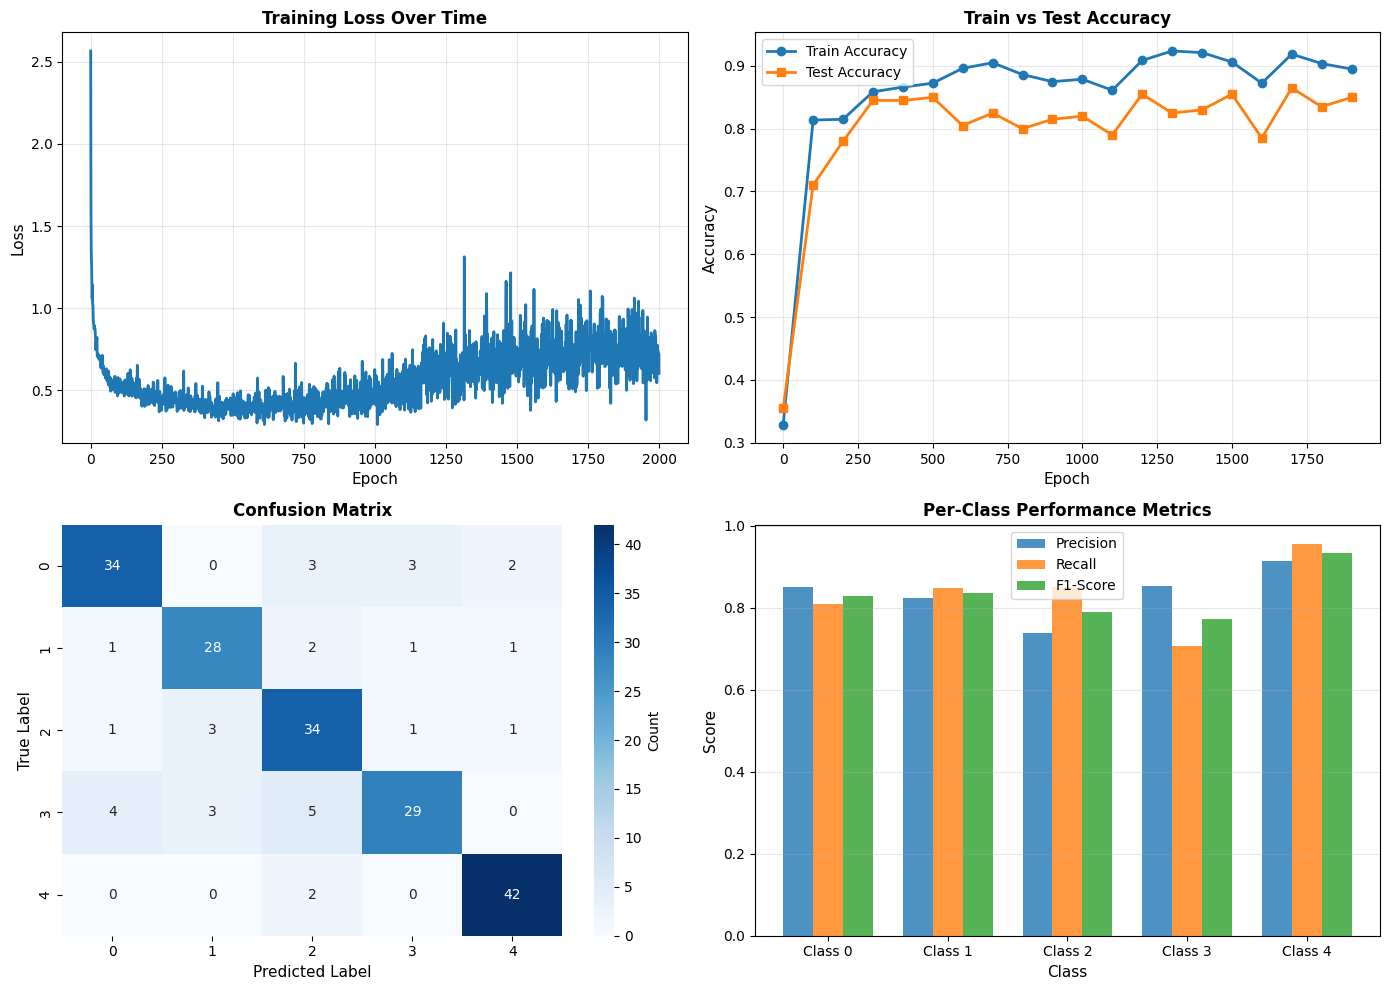

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes[0, 0].plot(train_losses, linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Loss', fontsize=11)
axes[0, 0].set_title('Training Loss Over Time', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

epochs_sampled = range(0, epochs, 100)
axes[0, 1].plot(epochs_sampled, train_accuracies, label='Train Accuracy', linewidth=2, marker='o')
axes[0, 1].plot(epochs_sampled, test_accuracies, label='Test Accuracy', linewidth=2, marker='s')
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Accuracy', fontsize=11)
axes[0, 1].set_title('Train vs Test Accuracy', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0], cbar_kws={'label': 'Count'})
axes[1, 0].set_xlabel('Predicted Label', fontsize=11)
axes[1, 0].set_ylabel('True Label', fontsize=11)
axes[1, 0].set_title('Confusion Matrix', fontsize=12, fontweight='bold')

x_pos = np.arange(5)
width = 0.25
axes[1, 1].bar(x_pos - width, precision, width, label='Precision', alpha=0.8)
axes[1, 1].bar(x_pos, recall, width, label='Recall', alpha=0.8)
axes[1, 1].bar(x_pos + width, f1, width, label='F1-Score', alpha=0.8)
axes[1, 1].set_xlabel('Class', fontsize=11)
axes[1, 1].set_ylabel('Score', fontsize=11)
axes[1, 1].set_title('Per-Class Performance Metrics', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels([f'Class {i}' for i in range(5)])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()
print()

#Conclusion

###1. Overall Accuracy: 0.8350

###2. per class f1 score 0.82 to 0.93

###3. used 2000 epocs

###4. prevented oerfitting problem in training

###5. Hyperparameter tuned,used batch normalization